In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp -r /content/gdrive/My\ Drive/fer2013.csv /content/

In [0]:
!cp -r /content/gdrive/My\ Drive/training_withReg /content/

In [0]:
import sys, os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

data = pd.read_csv('/content/fer2013.csv')
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [0]:
num_features = 64
num_labels = 7
batch_size = 2048
epochs = 100
width, height = 48, 48

In [0]:
pixels = data['pixels'].tolist() # 1

faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')] # 2
    face = np.asarray(face).reshape(width, height) # 3
    
    # There is an issue for normalizing images. Just comment out 4 and 5 lines until when I found the solution.
    # face = face / 255.0 # 4
    # face = cv2.resize(face.astype('uint8'), (width, height)) # 5
    faces.append(face.astype('float32'))

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1) # 6

emotions = pd.get_dummies(data['emotion']).to_numpy() # 7

In [0]:
X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)
print(X_train.shape, y_train.shape)

(29068, 48, 48, 1) (29068, 7)


In [0]:
from sklearn.utils import shuffle
import imgaug.augmenters as iaa
x_train_temp = X_train
y_tr_temp = y_train
newX_tr = []
newY_tr = []
for img in range(len(x_train_temp)) :
    flip_hr=iaa.Fliplr(p=1.0)
    flip_hr_image= flip_hr.augment_image(x_train_temp[img])
    newX_tr.append(flip_hr_image)
    newY_tr.append(y_tr_temp[img])

    gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
    noise_image=gaussian_noise.augment_image(x_train_temp[img])
    newX_tr.append(noise_image)
    newY_tr.append(y_tr_temp[img])

newX_tr = np.asarray(newX_tr)
newY_tr = np.asarray(newY_tr)
X_train = np.append(X_train,newX_tr, axis = 0)
y_train = np.append(y_train,newY_tr, axis = 0)

X_train,y_train = shuffle(X_train,y_train, random_state=2)
print(X_train.shape, y_train.shape)

(87204, 48, 48, 1) (87204, 7)


In [0]:
def plot(training_results, validation_results, results_type, model_name="dexpression"):
    fig = plt.figure(figsize=[8, 6])

    plt.plot(training_results, 'r', linewidth=3.0)
    plt.plot(validation_results, 'b', linewidth=3.0)
    plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(results_type, fontsize=16)
    plt.title(results_type + ' of ' + model_name, fontsize=16)

## Proposed Model

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D , BatchNormalization,concatenate ,Flatten,Dropout,Dense
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt

input_shape=(48,48,1)

padding='VALID'
dropout_rate=0.6

inp = Input(shape=input_shape)
X = ZeroPadding2D(padding=(3, 3))(inp)
X = Conv2D(filters = 64, kernel_size = (7, 7), strides = (1,1),kernel_regularizer=regularizers.l2(0.01), padding = "valid", activation = 'relu')(inp)
X = MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding=padding)(X)
X = BatchNormalization()(X)


X_1 = Conv2D(filters = 96, kernel_size = (1,1), strides = (1,1), padding = "valid", activation = 'relu')(X)
X_1 = ZeroPadding2D(padding=(1, 1))(X_1)
X_1 = Conv2D(filters = 208, kernel_size = (3,3), strides = (1,1), padding = "valid", activation = 'relu')(X_1)
X_1 = Dropout(0)(X_1)

X_2 = MaxPooling2D(pool_size=(3, 3),strides=(1,1),padding="same")(X)
X_2 = Conv2D(filters = 64, kernel_size = (1,1), kernel_regularizer=regularizers.l2(0.01),strides = (1,1), padding = "valid", activation = 'relu')(X_2)
X_2 = Dropout(0)(X_2)

merged = concatenate([X_1, X_2], axis=3)
merged = MaxPooling2D(pool_size=(3, 3),strides=1,padding=padding)(merged)

merged_1 = Conv2D(filters = 96, kernel_size = (1,1), strides = (1,1), padding = "valid", activation = 'relu')(merged)
merged_1 = ZeroPadding2D(padding=(1, 1))(merged_1)
merged_1 = Conv2D(filters = 208, kernel_size = (3,3), strides = (1,1), padding = "valid", activation = 'relu')(merged_1)
merged_1 = Dropout(0.25)(merged_1)

merged_2 = MaxPooling2D(pool_size=(3, 3),strides=1,padding="same")(merged)
merged_2 = Conv2D(filters = 64, kernel_size = (1,1), kernel_regularizer=regularizers.l2(0.01),strides = (1,1), padding = "valid", activation = 'relu')(merged_2)
out = concatenate([merged_1, merged_2], axis=3)
out = MaxPooling2D(pool_size=(3, 3),strides=1,padding=padding)(out)

merged_3 = Conv2D(filters = 96, kernel_size = (1,1),kernel_regularizer=regularizers.l2(0.01), strides = (1,1), padding = "valid", activation = 'relu')(out)
merged_3 = ZeroPadding2D(padding=(1, 1))(merged_3)
merged_3 = Conv2D(filters = 208,kernel_regularizer=regularizers.l2(0.01), kernel_size = (3,3), strides = (1,1), padding = "valid", activation = 'relu')(merged_3)
merged_3 = Dropout(0.4)(merged_3)

merged_4 = MaxPooling2D(pool_size=(3, 3),strides=1,padding="same")(merged_3)
merged_4 = Conv2D(filters = 64, kernel_size = (1,1), strides = (1,1), kernel_regularizer=regularizers.l2(0.01), padding = "valid", activation = 'relu')(merged_4)
out_2 = concatenate([merged_3, merged_4], axis=3)
out_2 = MaxPooling2D(pool_size=(3, 3),strides=1,padding=padding)(out_2)

out_2 = Flatten()(out_2)
out_2 = Dropout(0.3)(out_2)
out_2 = Dense(7, activation="softmax", kernel_regularizer=regularizers.l2(0.01))(out_2)
model = Model(inputs = inp, outputs = out_2)

checkpoint_path = "/content/training_withReg/cp.ckpt"
model.load_weights(checkpoint_path)

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint("/content/training_withReg/cp.ckpt",monitor='val_loss', verbose=1, save_weights_only=True,save_best_only=True)

In [0]:
hist = model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_val), np.array(y_val)),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])
plot(hist.history['accuracy'], hist.history['val_accuracy'], 'Accuracy')
plot(hist.history['loss'], hist.history['val_loss'], 'Loss')

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 0.7931 - accuracy: 0.8465 
Epoch 00001: val_loss improved from inf to 1.56059, saving model to /content/training_withReg/cp.ckpt
43/43 [==============================] - 1520s 35s/step - loss: 0.7931 - accuracy: 0.8465 - val_loss: 1.5606 - val_accuracy: 0.5731 - lr: 4.7830e-04
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.7608 - accuracy: 0.8554 
Epoch 00002: val_loss improved from 1.56059 to 1.53590, saving model to /content/training_withReg/cp.ckpt
43/43 [==============================] - 1520s 35s/step - loss: 0.7608 - accuracy: 0.8554 - val_loss: 1.5359 - val_accuracy: 0.5876 - lr: 4.7830e-04
Epoch 3/100
43/43 [==============================] - ETA: 0s - loss: 0.7571 - accuracy: 0.8511 
Epoch 00003: val_loss improved from 1.53590 to 1.52265, saving model to /content/training_withReg/cp.ckpt
43/43 [==============================] - 1511s 35s/step - loss: 0.7571 - accuracy: 0.8511 - val_loss

In [0]:
preds = model.evaluate(np.array(X_test), np.array(y_test), batch_size=batch_size)
print ("Testing Loss = " + str(preds[0]))
print ("Testing Accuracy = " + str(preds[1]))

2/2 [==============================] - 6s 3s/step - loss: 1.2365 - accuracy: 0.5885
Testing Loss = 1.2365093231201172
Testing Accuracy = 0.5884647369384766


In [0]:
preds = model.evaluate(np.array(X_val), np.array(y_val), batch_size=batch_size)
print ("Testing Loss = " + str(preds[0]))
print ("Testing Accuracy = " + str(preds[1]))

2/2 [==============================] - 4s 2s/step - loss: 1.2215 - accuracy: 0.6009
Testing Loss = 1.2215290069580078
Testing Accuracy = 0.600928783416748


In [0]:
!cp -r /content/fer2013.csv /content/gdrive/My\ Drive/

In [0]:
!cp -r /content/training_withReg_4 /content/gdrive/My\ Drive/

In [0]:
checkpoint_path = "/content/training_withReg/cp.ckpt"
model.load_weights(checkpoint_path)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f74be9cf860> and <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f74be9e07f0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f74be9e0f98> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f74be975d68>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f74be9eae80> and <tensorflow.python.keras.layers.merge.Concatenate object at 0x7f74be97bef0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f74cb642748> and <tensorflow.python.keras.layers.merge.Concatenate object at 0x7f74cb658630>).


# ResNet

In [0]:
import numpy as np
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, recall_score, precision_score


from tensorflow.keras import layers
from keras.layers import SeparableConv2D
from tensorflow.keras.layers import Input, Add, Dense, Activation,Convolution2D, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import  to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import tensorflow.keras.backend as K

Using TensorFlow backend.


In [0]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

#convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X



In [0]:
def ResNet50(input_shape = (32, 32, 3), classes = 14):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='c')
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [256,256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256,256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256,256, 1024], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), name='avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [0]:
model = ResNet50(input_shape = (48, 48, 1), classes = 7)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 32)   1600        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 32)   128         conv1[0][0]                      
___________________________________________________________________________________________

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 1.9157 - accuracy: 0.2748
Epoch 00001: val_loss improved from inf to 597.60278, saving model to /content/training_Res/cp.ckpt
43/43 [==============================] - 20s 462ms/step - loss: 1.9157 - accuracy: 0.2748 - val_loss: 597.6028 - val_accuracy: 0.1433 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 1.5903 - accuracy: 0.3929
Epoch 00002: val_loss improved from 597.60278 to 2.49578, saving model to /content/training_Res/cp.ckpt
43/43 [==============================] - 17s 400ms/step - loss: 1.5903 - accuracy: 0.3929 - val_loss: 2.4958 - val_accuracy: 0.1913 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - ETA: 0s - loss: 1.4544 - accuracy: 0.4536
Epoch 00003: val_loss did not improve from 2.49578
43/43 [==============================] - 17s 390ms/step - loss: 1.4544 - accuracy: 0.4536 - val_loss: 26.8323 - val_accuracy: 0.2393 - lr: 0.0010
Epoch 4/100
43/43 [===

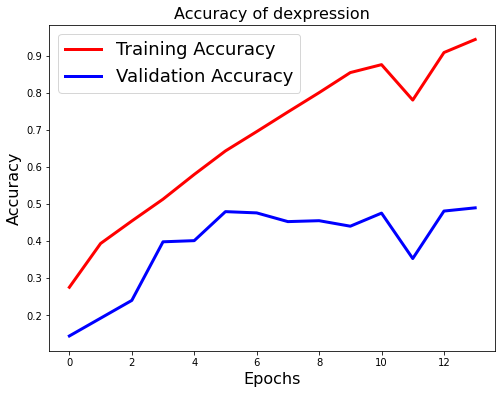

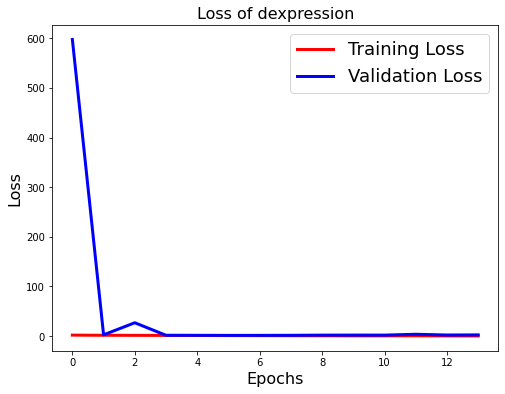

In [0]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint("/content/training_Res/cp.ckpt",monitor='val_loss', verbose=1, save_weights_only=True,save_best_only=True)
hist = model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_val), np.array(y_val)),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])
plot(hist.history['accuracy'], hist.history['val_accuracy'], 'Accuracy')
plot(hist.history['loss'], hist.history['val_loss'], 'Loss')

In [0]:
preds = model.evaluate(np.array(X_test), np.array(y_test), batch_size=batch_size)
print ("Testing Loss = " + str(preds[0]))
print ("Testing Accuracy = " + str(preds[1]))

2/2 [==============================] - 1s 297ms/step - loss: 2.3899 - accuracy: 0.4962
Testing Loss = 2.389908790588379
Testing Accuracy = 0.49623849987983704


# CNN_1

In [0]:
def my_CNN(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(5, kernel_size=(3, 3), padding='same',
                            name='image_array', input_shape=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(10, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=num_classes, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Activation('softmax',name='predictions'))
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_array (Conv2D)         (None, 48, 48, 5)         50        
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 48, 5)         20        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 10)        460       
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 24, 10)        40        
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 10)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 16)        1456      
_________________________________________________________________
batch_normalization_8 (Batch (None, 12, 12, 16)       

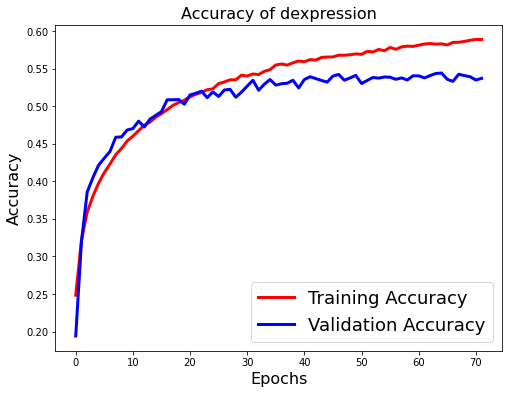

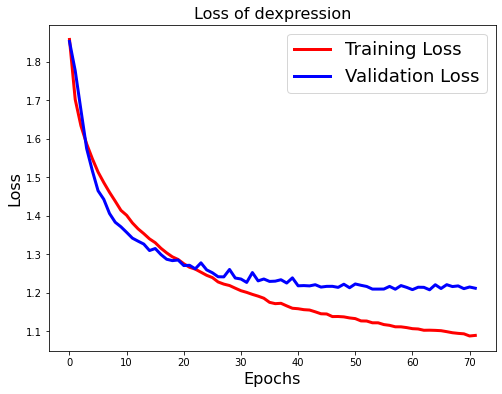

In [0]:
model = my_CNN((48,48,1), 7)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint("/content/training_Res/cp.ckpt",monitor='val_loss', verbose=1, save_weights_only=True,save_best_only=True)
hist = model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_val), np.array(y_val)),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])
plot(hist.history['accuracy'], hist.history['val_accuracy'], 'Accuracy')
plot(hist.history['loss'], hist.history['val_loss'], 'Loss')

In [0]:
preds = model.evaluate(np.array(X_test), np.array(y_test), batch_size=batch_size)
print ("Testing Loss = " + str(preds[0]))
print ("Testing Accuracy = " + str(preds[1]))

2/2 [==============================] - 0s 37ms/step - loss: 1.2271 - accuracy: 0.5417
Testing Loss = 1.2271398305892944
Testing Accuracy = 0.5416550636291504


# tiny_XCEPTION

In [0]:
from tensorflow.keras.layers import Activation, Convolution2D, Dropout, Conv2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

In [0]:
def tiny_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(5, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(5, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(8, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(8, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(8, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 46, 46, 5)    45          input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 46, 46, 5)    20          conv2d_17[0][0]                  
__________________________________________________________________________________________________
activation_53 (Activation)      (None, 46, 46, 5)    0           batch_normalization_18[0][0]     
______________________________________________________________________________________________

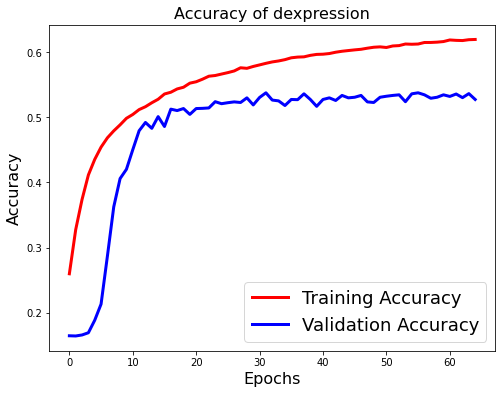

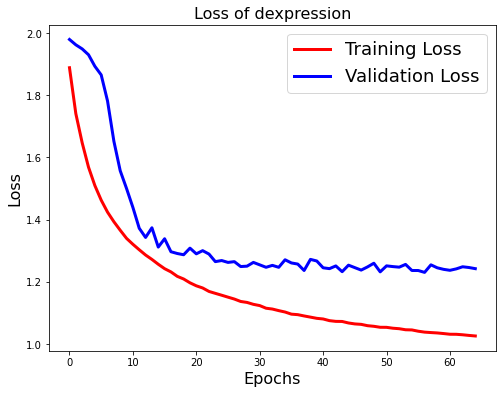

In [0]:
model = tiny_XCEPTION((48,48,1), 7)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint("/content/training_Res/cp.ckpt",monitor='val_loss', verbose=1, save_weights_only=True,save_best_only=True)
hist = model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_val), np.array(y_val)),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])
plot(hist.history['accuracy'], hist.history['val_accuracy'], 'Accuracy')
plot(hist.history['loss'], hist.history['val_loss'], 'Loss')

In [0]:
preds = model.evaluate(np.array(X_test), np.array(y_test), batch_size=batch_size)
print ("Testing Loss = " + str(preds[0]))
print ("Testing Accuracy = " + str(preds[1]))

2/2 [==============================] - 0s 78ms/step - loss: 1.2565 - accuracy: 0.5286
Testing Loss = 1.25651216506958
Testing Accuracy = 0.5285595059394836


## Big_Xception

In [0]:
def big_XCEPTION(input_shape, num_classes):
    img_input = Input(input_shape)
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False)(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])
    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 23, 23, 32)   288         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 23, 23, 32)   128         conv2d_24[0][0]                  
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 23, 23, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

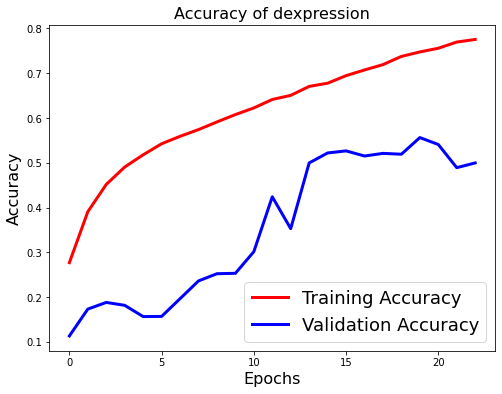

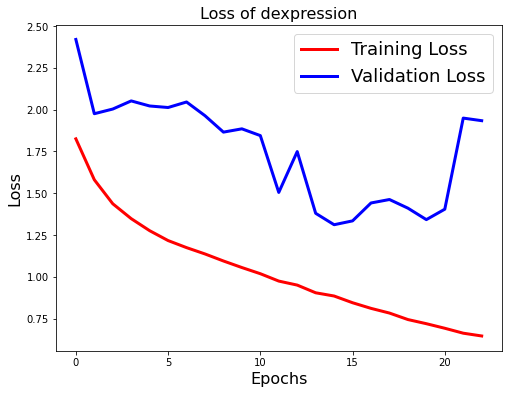

In [0]:
model = big_XCEPTION((48,48,1), 7)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint("/content/training_Res/cp.ckpt",monitor='val_loss', verbose=1, save_weights_only=True,save_best_only=True)
hist = model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_val), np.array(y_val)),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])
plot(hist.history['accuracy'], hist.history['val_accuracy'], 'Accuracy')
plot(hist.history['loss'], hist.history['val_loss'], 'Loss')
preds = model.evaluate(np.array(X_test), np.array(y_test), batch_size=batch_size)
print ("Testing Loss = " + str(preds[0]))
print ("Testing Accuracy = " + str(preds[1]))

## CNN_2

In [0]:
def my_newCNN(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same',
                            name='image_array', input_shape=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(SeparableConv2D(32, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same',
                           strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same',
                            strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(num_classes))
    model.add(Flatten())
    model.add(Activation('softmax',name='predictions'))
    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_array (Conv2D)         (None, 48, 48, 16)        160       
_________________________________________________________________
batch_normalization_34 (Batc (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 24, 24, 16)        2320      
_________________________________________________________________
batch_normalization_35 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 16)        0         
_________________________________________________________________
separable_conv2d_12 (Separab (None, 12, 12, 32)        688       
_________________________________________________________________
batch_normalization_36 (Batc (None, 12, 12, 32)       

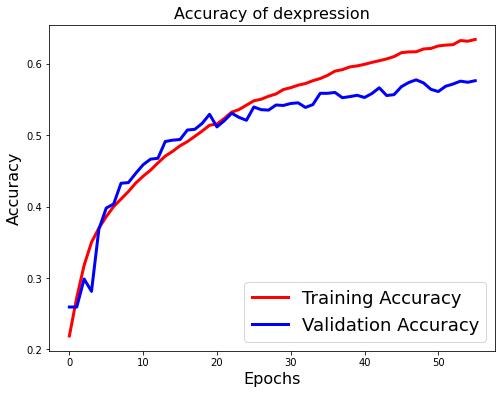

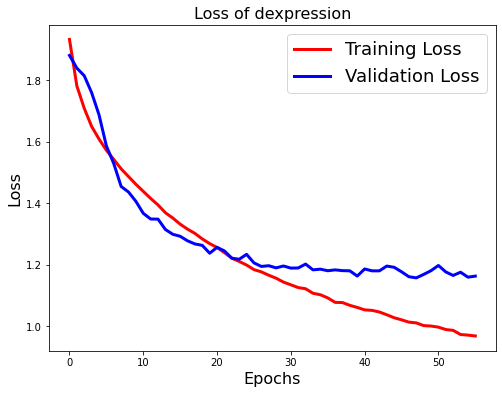

In [0]:
model = my_newCNN((48,48,1), 7)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint("/content/training_Res/cp.ckpt",monitor='val_loss', verbose=1, save_weights_only=True,save_best_only=True)
hist = model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_val), np.array(y_val)),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])
plot(hist.history['accuracy'], hist.history['val_accuracy'], 'Accuracy')
plot(hist.history['loss'], hist.history['val_loss'], 'Loss')
preds = model.evaluate(np.array(X_test), np.array(y_test), batch_size=batch_size)
print ("Testing Loss = " + str(preds[0]))
print ("Testing Accuracy = " + str(preds[1]))

#**NEW Strategy FER2013_3_lables**

In [0]:
import cv2
import math
import joblib
import numpy as np
import pandas as pd


import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp -r /content/gdrive/My\ Drive/fer2013.csv /content/

In [0]:
df = pd.read_csv('/content/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
df.emotion.unique()
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
df.emotion.value_counts()
print(emotion_label_to_text)

{0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}


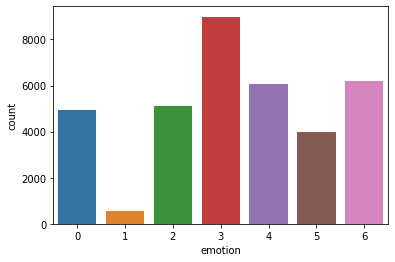

(35887,)


In [0]:
sns.countplot(df.emotion)
pyplot.show()
print(df.emotion.shape)

In [0]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

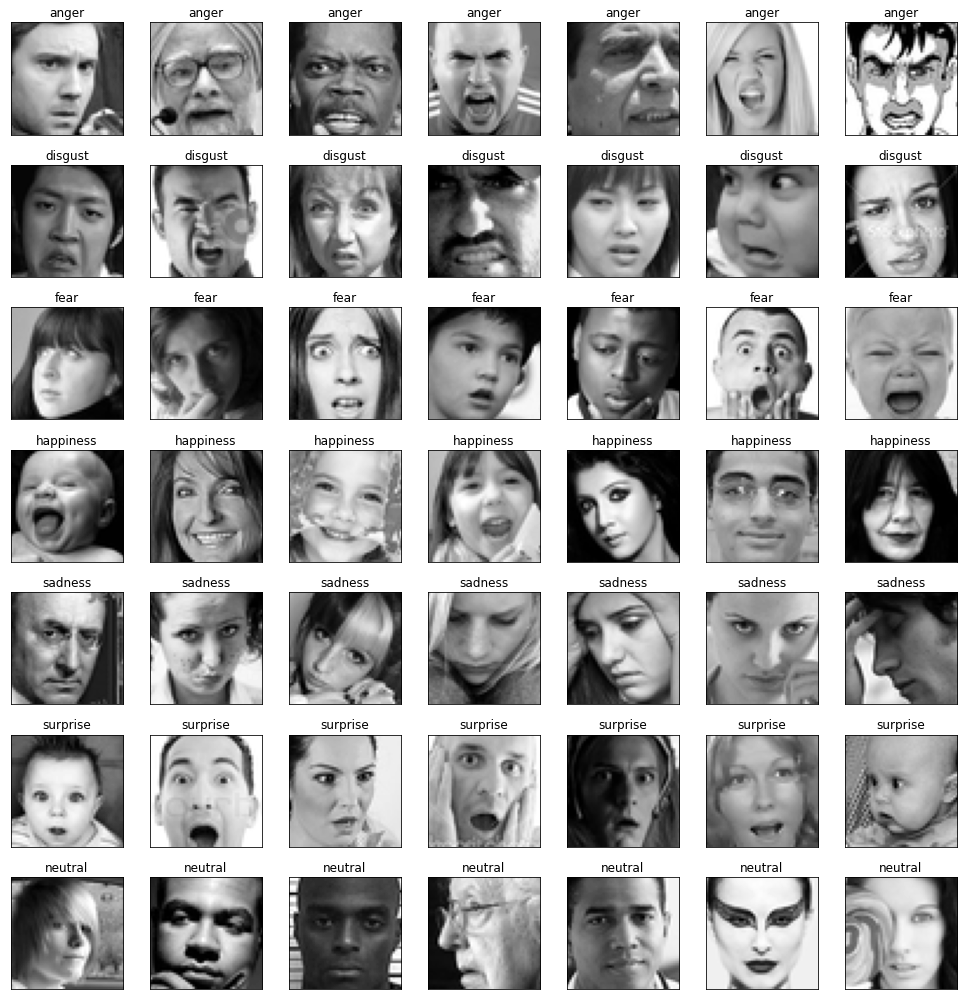

In [0]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [0]:
#INTERESTED_LABELS = [3, 4, 6]
#df = df[df.emotion.isin(INTERESTED_LABELS)]
#df.shape


In [0]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array.shape

(35887, 48, 48, 1)

In [0]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [0]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [0]:
img_labels[:,3].sum()

8989.0

In [0]:
newX_tr=[]
newY_tr=[]
import imgaug.augmenters as iaa
import random

for i in range(len(img_array)):
  if (emotion_label_to_text[np.argmax(img_labels[i])]=='surprise'):
      gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
      noise_image=gaussian_noise.augment_image(img_array[i])
      newX_tr.append(noise_image)
      newY_tr.append(img_labels[i])
  if (emotion_label_to_text[np.argmax(img_labels[i])]=='sadness'):
    p= random.uniform(0, 1)
    if(p<0.5):
      gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
      noise_image=gaussian_noise.augment_image(img_array[i])
      newX_tr.append(noise_image)
      newY_tr.append(img_labels[i])
  if (emotion_label_to_text[np.argmax(img_labels[i])]=='neutral'):
    p= random.uniform(0, 1)
    if(p<0.5):
      gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
      noise_image=gaussian_noise.augment_image(img_array[i])
      newX_tr.append(noise_image)
      newY_tr.append(img_labels[i])
  if (emotion_label_to_text[np.argmax(img_labels[i])]=='fear'):
    p= random.uniform(0, 1)
    if(p<0.8):
      gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
      noise_image=gaussian_noise.augment_image(img_array[i])
      newX_tr.append(noise_image)
      newY_tr.append(img_labels[i])
  if (emotion_label_to_text[np.argmax(img_labels[i])]=='anger'):
    p= random.uniform(0, 1)
    if(p<0.8):
      gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
      noise_image=gaussian_noise.augment_image(img_array[i])
      newX_tr.append(noise_image)
      newY_tr.append(img_labels[i])
  if (emotion_label_to_text[np.argmax(img_labels[i])]=='disgust'):
    flip_hr=iaa.Fliplr(p=1.0)
    flip_hr_image= flip_hr.augment_image(img_array[i])
    newX_tr.append(flip_hr_image)
    newY_tr.append(img_labels[i])

    con=iaa.LinearContrast((0.5, 2.0), per_channel=0.5)
    con_image = con.augment_image(img_array[i])
    newX_tr.append(con_image)
    newY_tr.append(img_labels[i])

    con2=iaa.LinearContrast((0.25, 1.0), per_channel=0.25)
    con_image2 = con2.augment_image(img_array[i])
    newX_tr.append(con_image2)
    newY_tr.append(img_labels[i])

    sh = iaa.Sharpen(alpha=.2, lightness=(0.75, 1.5))
    sh_image = sh.augment_image(img_array[i])
    newX_tr.append(sh_image)
    newY_tr.append(img_labels[i])

    sh2 = iaa.Sharpen(alpha=.1, lightness=(0.5, 1.25))
    sh_image2 = sh2.augment_image(img_array[i])
    newX_tr.append(sh_image2)
    newY_tr.append(img_labels[i])

    croped = iaa.Crop(percent=(0, 0.02))
    croped_image = croped.augment_image(img_array[i])
    newX_tr.append(croped_image)
    newY_tr.append(img_labels[i])

    croped2 = iaa.Crop(percent=(0, 0.01))
    croped_image2 = croped2.augment_image(img_array[i])
    newX_tr.append(croped_image2)
    newY_tr.append(img_labels[i])

    croped3 = iaa.Crop(percent=(0, 0.03))
    croped_image3 = croped3.augment_image(img_array[i])
    newX_tr.append(croped_image3)
    newY_tr.append(img_labels[i])

    gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
    noise_image=gaussian_noise.augment_image(img_array[i])
    newX_tr.append(noise_image)
    newY_tr.append(img_labels[i])

    gaussian_noise2=iaa.AdditiveGaussianNoise(5,10)
    noise_image2=gaussian_noise2.augment_image(img_array[i])
    newX_tr.append(noise_image2)
    newY_tr.append(img_labels[i])

    gaussian_noise3=iaa.AdditiveGaussianNoise(1,5)
    noise_image3=gaussian_noise3.augment_image(img_array[i])
    newX_tr.append(noise_image3)
    newY_tr.append(img_labels[i])
    
  newX_tr.append(img_array[i])
  newY_tr.append(img_labels[i])

newX_tr = np.array(newX_tr)
newY_tr = np.array(newY_tr)

In [0]:
print(newX_tr.shape)
print(newY_tr.shape)
img_labels=newY_tr
img_array=newX_tr

(60061, 48, 48, 1)
(60061, 7)


In [0]:
data=[]
for i in range(int(img_labels[:,0].sum())):
  data.append(0)
for i in range(int(img_labels[:,1].sum())):
  data.append(1)
for i in range(int(img_labels[:,2].sum())):
  data.append(2)
for i in range(int(img_labels[:,3].sum())):
  data.append(3)
for i in range(int(img_labels[:,4].sum())):
  data.append(4)
for i in range(int(img_labels[:,5].sum())):
  data.append(5)
for i in range(int(img_labels[:,6].sum())):
  data.append(6)
print(np.array(data).shape)

(60061,)


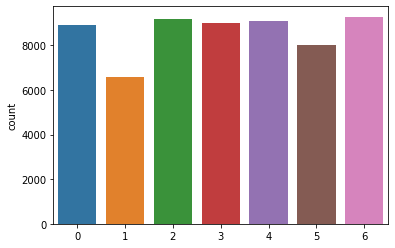

In [0]:
sns.countplot(data)
pyplot.show()

In [0]:
print("extracting HOG features, this may take some minutes...")

hog_feats = []
for img in img_array:
    img = img.astype("uint8")
    img_ = cv2.resize(img, (64,128))
    # img_ = cv2.equalizeHist(img_)

    hog = cv2.HOGDescriptor()
    hog_descr = hog.compute(img_)
    hog_feats.append(hog_descr)


hog_feats = np.array(hog_feats)
print(hog_feats.shape)


extracting HOG features, this may take some minutes...
(60144, 3780, 1)


In [0]:
Xtrain_img, Xvalid_img, Xtrain_hog, Xvalid_hog, y_train, y_valid = \
train_test_split(img_array, hog_feats, img_labels,
                shuffle=True, stratify=img_labels, test_size=0.1,
                random_state=42)

print(Xtrain_img.shape, Xtrain_hog.shape, y_train.shape)
print(Xvalid_img.shape, Xvalid_hog.shape, y_valid.shape)

(54129, 48, 48, 1) (54129, 3780, 1) (54129, 7)
(6015, 48, 48, 1) (6015, 3780, 1) (6015, 7)


In [0]:
img_width = Xtrain_img.shape[1]
img_height = Xtrain_img.shape[2]
img_depth = Xtrain_img.shape[3]
num_classes = y_train.shape[1]
# Normalizing image arrays
Xtrain_img = Xtrain_img / 255.
Xvalid_img = Xvalid_img / 255.

In [0]:
def dcnn_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_DCNN")
    
    conv2d_1 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(batchnorm_2)
    dropout_1 = Dropout(0.4, name='dropout_1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(batchnorm_4)
    dropout_2 = Dropout(0.4, name='dropout_2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(batchnorm_6)
    dropout_3 = Dropout(0.4, name='dropout_3')(maxpool2d_3)

    flatten = Flatten(name='flatten_dcnn')(dropout_3)
        
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1_dcnn'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7')(dense_1)
    
    model_out = Dropout(0.6, name='dropout_4')(batchnorm_7)
    
    return model_in, model_out



In [0]:
def facial_HOG_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_Facial_HOG")
    flatten = Flatten(name="flatten_hog")(model_in)
    dense1 = Dense(256, activation="relu", name="dense1_hog")(flatten)
    model_out = Dropout(0.4, name='dropout1_hog')(dense1)
        
    return model_in, model_out

In [0]:
def merge_models(models_in: list, models_out: list, num_classes: int, show_summary=False):
    
    concated = Concatenate()(models_out)
    dropout_1 = Dropout(0.4, name='dropout1_model')(concated)

    dense1 = Dense(256, activation="relu", name="dense1")(dropout_1)
    dropout_2 = Dropout(0.4, name='dropout2_model')(dense1)
    out = Dense(num_classes, activation="softmax", name="out_layer")(dropout_2)

    model = Model(inputs=models_in, outputs=out, name="FER_Model")

    if show_summary:
        model.summary()
    
    return model

In [0]:
dcnn_in, dcnn_out = dcnn_pipeline(input_shape=(48,48,1))
hog_in, hog_out = facial_HOG_pipeline(input_shape=(3780,1))

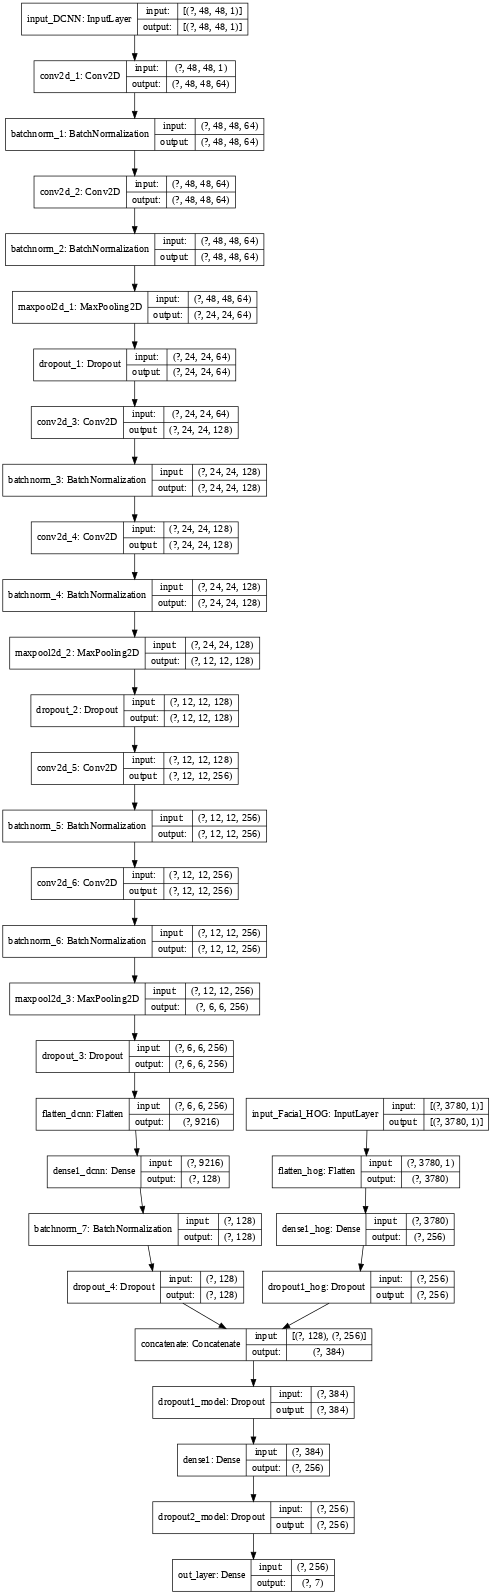

In [0]:
model = merge_models(
    models_in=[dcnn_in, hog_in],
    models_out=[dcnn_out, hog_out],
    num_classes=7
)
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='model_1.png')

In [0]:

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.00025,
    factor=0.25,
    patience=3,
    min_lr=1e-6,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [0]:
def data_generator(Xtrain_img, Xtain_hog, ytrain, batch_size):
    while True:
        idx = np.random.permutation(Xtrain_img.shape[0])

        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.15,
            height_shift_range=0.15,
            shear_range=0.15,
            zoom_range=0.15,
            horizontal_flip=True,
        )

        batches = datagen.flow(Xtrain_img[idx], ytrain[idx], batch_size=batch_size, shuffle=False)
        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]

            yield [batch[0], Xtain_hog[idx[ idx0:idx1 ]]], batch[1]

            idx0 = idx1
            if idx1 >= Xtrain_img.shape[0]:
                break

In [0]:
batch_size = 32
epochs = 100#45
lr = 0.001
optim = optimizers.Adam(learning_rate=lr)

model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

history = model.fit(
    data_generator(Xtrain_img, Xtrain_hog, y_train, batch_size=batch_size,),
    validation_data=([Xvalid_img, Xvalid_hog], y_valid),
    steps_per_epoch=len(Xtrain_img) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    #use_multiprocessing=True
)


Epoch 1/100
1692/1691 [==============================] - 26s 15ms/step - loss: 0.9217 - accuracy: 0.6566 - val_loss: 0.9346 - val_accuracy: 0.6638 - lr: 0.0010
Epoch 2/100
1692/1691 [==============================] - 26s 15ms/step - loss: 0.9390 - accuracy: 0.6485 - val_loss: 0.8840 - val_accuracy: 0.6735 - lr: 0.0010
Epoch 3/100
1692/1691 [==============================] - 26s 15ms/step - loss: 0.9367 - accuracy: 0.6514 - val_loss: 0.9145 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 4/100
1692/1691 [==============================] - 26s 15ms/step - loss: 0.9412 - accuracy: 0.6491 - val_loss: 0.9216 - val_accuracy: 0.6655 - lr: 0.0010
Epoch 5/100
1692/1691 [==============================] - 26s 15ms/step - loss: 0.9393 - accuracy: 0.6500 - val_loss: 0.8617 - val_accuracy: 0.6748 - lr: 0.0010
Epoch 6/100
1692/1691 [==============================] - 26s 15ms/step - loss: 0.9376 - accuracy: 0.6510 - val_loss: 0.9227 - val_accuracy: 0.6597 - lr: 0.0010
Epoch 7/100
1692/1691 [=================

144/144 [==============================] - 1s 5ms/step - loss: 0.7491 - accuracy: 0.7299
Testing Loss = 0.74905925989151
Testing Accuracy = 0.7299476861953735


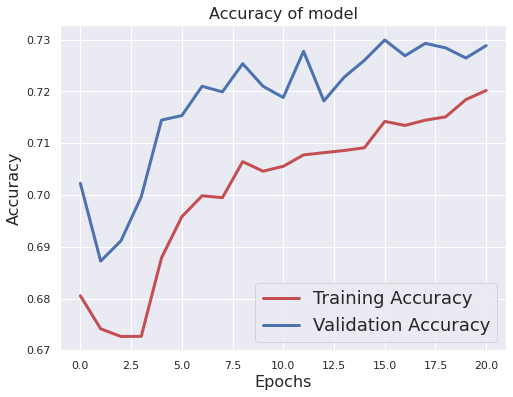

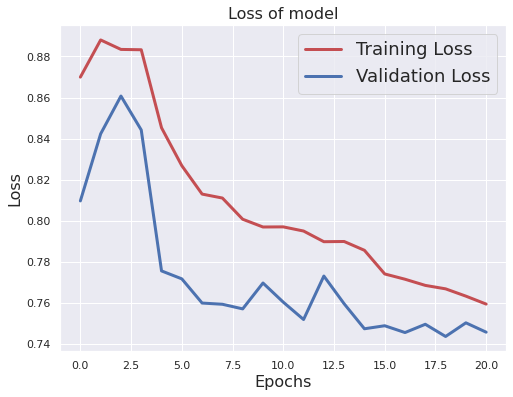

In [0]:
import matplotlib.pyplot as plt
def plot(training_results, validation_results, results_type, model_name="model"):
    fig = plt.figure(figsize=[8, 6])

    plt.plot(training_results, 'r', linewidth=3.0)
    plt.plot(validation_results, 'b', linewidth=3.0)
    plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(results_type, fontsize=16)
    plt.title(results_type + ' of ' + model_name, fontsize=16)
    
plot(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')
plot(history.history['loss'], history.history['val_loss'], 'Loss')
preds = model.evaluate([Xvalid_img, Xvalid_hog],y_valid, batch_size=batch_size)
print ("Testing Loss = " + str(preds[0]))
print ("Testing Accuracy = " + str(preds[1]))

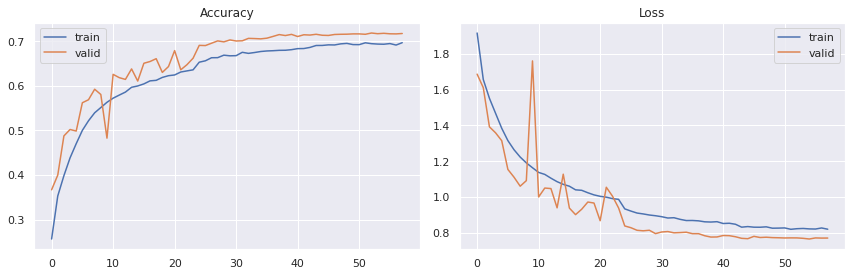

In [0]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_multipipe_model.png')
pyplot.show()


In [0]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("/content/gdrive/My Drive/model_73_7.h5")

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
yhat_valid = model.predict([Xvalid_img, Xvalid_hog])
yhat_valid = np.argmax(yhat_valid, axis=1)



print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))



total wrong validation predictions: 1239


              precision    recall  f1-score   support

           0       0.63      0.66      0.64       591
           1       0.89      0.99      0.94       657
           2       0.65      0.33      0.44       616
           3       0.88      0.91      0.89       899
           4       0.57      0.54      0.56       608
           5       0.78      0.82      0.80       597
           6       0.60      0.76      0.67       620

    accuracy                           0.73      4588
   macro avg       0.71      0.72      0.70      4588
weighted avg       0.73      0.73      0.72      4588



# **Ensemble**

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,AveragePooling2D, MaxPooling2D, ZeroPadding2D , Activation, BatchNormalization,concatenate ,Flatten,Dropout,Dense
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.optimizers import Adam,Adadelta, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import applications

In [0]:
df = pd.read_csv('/content/fer2013.csv')
print(df.shape)
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array.shape

(35887, 3)


(35887, 48, 48, 1)

In [0]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [0]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [0]:
newX_tr=[]
newY_tr=[]
import imgaug.augmenters as iaa
import random

for i in range(len(img_array)):
  if (emotion_label_to_text[np.argmax(img_labels[i])]=='surprise'):
    p= random.uniform(0, 1)
    if(p<0.4):
      gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
      noise_image=gaussian_noise.augment_image(img_array[i])
      newX_tr.append(noise_image)
      newY_tr.append(img_labels[i])
  if (emotion_label_to_text[np.argmax(img_labels[i])]=='fear'):
    p= random.uniform(0, 1)
    if(p<0.2):
      gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
      noise_image=gaussian_noise.augment_image(img_array[i])
      newX_tr.append(noise_image)
      newY_tr.append(img_labels[i])
  if (emotion_label_to_text[np.argmax(img_labels[i])]=='anger'):
    p= random.uniform(0, 1)
    if(p<0.2):
      gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
      noise_image=gaussian_noise.augment_image(img_array[i])
      newX_tr.append(noise_image)
      newY_tr.append(img_labels[i])
  if (emotion_label_to_text[np.argmax(img_labels[i])]=='disgust'):
    flip_hr=iaa.Fliplr(p=1.0)
    flip_hr_image= flip_hr.augment_image(img_array[i])
    newX_tr.append(flip_hr_image)
    newY_tr.append(img_labels[i])

    con=iaa.LinearContrast((0.5, 2.0), per_channel=0.5)
    con_image = con.augment_image(img_array[i])
    newX_tr.append(con_image)
    newY_tr.append(img_labels[i])

    con2=iaa.LinearContrast((0.25, 1.0), per_channel=0.25)
    con_image2 = con2.augment_image(img_array[i])
    newX_tr.append(con_image2)
    newY_tr.append(img_labels[i])

    sh = iaa.Sharpen(alpha=.2, lightness=(0.75, 1.5))
    sh_image = sh.augment_image(img_array[i])
    newX_tr.append(sh_image)
    newY_tr.append(img_labels[i])

    sh2 = iaa.Sharpen(alpha=.1, lightness=(0.5, 1.25))
    sh_image2 = sh2.augment_image(img_array[i])
    newX_tr.append(sh_image2)
    newY_tr.append(img_labels[i])

    croped = iaa.Crop(percent=(0, 0.02))
    croped_image = croped.augment_image(img_array[i])
    newX_tr.append(croped_image)
    newY_tr.append(img_labels[i])

    croped2 = iaa.Crop(percent=(0, 0.01))
    croped_image2 = croped2.augment_image(img_array[i])
    newX_tr.append(croped_image2)
    newY_tr.append(img_labels[i])

    gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
    noise_image=gaussian_noise.augment_image(img_array[i])
    newX_tr.append(noise_image)
    newY_tr.append(img_labels[i])

    gaussian_noise2=iaa.AdditiveGaussianNoise(5,10)
    noise_image2=gaussian_noise2.augment_image(img_array[i])
    newX_tr.append(noise_image2)
    newY_tr.append(img_labels[i])
    
  newX_tr.append(img_array[i])
  newY_tr.append(img_labels[i])

newX_tr = np.array(newX_tr)
newY_tr = np.array(newY_tr)

In [0]:
print(newX_tr.shape)
print(newY_tr.shape)
img_labels=newY_tr
img_array=newX_tr

(44448, 48, 48, 1)
(44448, 7)


In [0]:
print("extracting HOG features, this may take some minutes...")

hog_feats = []
for img in img_array:
    img = img.astype("uint8")
    img_ = cv2.resize(img, (64,128))
    # img_ = cv2.equalizeHist(img_)

    hog = cv2.HOGDescriptor()
    hog_descr = hog.compute(img_)
    hog_feats.append(hog_descr)


hog_feats = np.array(hog_feats)
print(hog_feats.shape)

extracting HOG features, this may take some minutes...
(44448, 3780, 1)


In [0]:
Xtrain_img, Xvalid_img, Xtrain_hog, Xvalid_hog, y_train, y_valid = \
train_test_split(img_array, hog_feats, img_labels,
                shuffle=True, stratify=img_labels, test_size=0.1,
                random_state=42)

print(Xtrain_img.shape, Xtrain_hog.shape, y_train.shape)
print(Xvalid_img.shape, Xvalid_hog.shape, y_valid.shape)

(40003, 48, 48, 1) (40003, 3780, 1) (40003, 7)
(4445, 48, 48, 1) (4445, 3780, 1) (4445, 7)


In [0]:
img_width = Xtrain_img.shape[1]
img_height = Xtrain_img.shape[2]
img_depth = Xtrain_img.shape[3]
num_classes = y_train.shape[1]
# Normalizing image arrays
Xtrain_img = Xtrain_img / 255.
Xvalid_img = Xvalid_img / 255.

In [0]:
def model_orig(input_shape=(48,48,1), num_classes=7):
    padding = 'same'
    inp = Input(shape=input_shape)
    # START MODEL
    conv_1 = Conv2D(64, (7, 7), strides=(2, 2), padding=padding, activation='relu', name='conv_1')(inp)
    maxpool_1 = MaxPooling2D((3, 3), strides=(2,2))(conv_1)
    maxpool_1 = Dropout(0.3)(maxpool_1)
    x = BatchNormalization()(maxpool_1)
    
    # FEAT-EX1
    conv_2a = Conv2D(96, (1, 1), strides=(1,1), activation='relu', padding=padding, name='conv_2a')(x)
    conv_2b = Conv2D(208, (3, 3), strides=(1,1), activation='relu', padding=padding, name='conv_2b')(conv_2a)
    maxpool_2a = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_2a')(x)
    maxpool_2a = Dropout(0.3)(maxpool_2a)
    conv_2c = Conv2D(64, (1, 1), strides=(1,1), name='conv_2c')(maxpool_2a)
    concat_1 = concatenate([conv_2b,conv_2c],axis=3,name='concat_2')
    maxpool_2b = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_2b')(concat_1)
    maxpool_2b = Dropout(0.3)(maxpool_2b)
    
    # FEAT-EX2
    conv_3a = Conv2D(96, (1, 1), strides=(1,1), activation='relu', padding=padding, name='conv_3a')(maxpool_2b)
    conv_3b = Conv2D(208, (3, 3), strides=(1,1), activation='relu', padding=padding, name='conv_3b')(conv_3a)
    maxpool_3a = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_3a')(maxpool_2b)
    maxpool_3a = Dropout(0.3)(maxpool_3a)
    conv_3c = Conv2D(64, (1, 1), strides=(1,1), name='conv_3c')(maxpool_2a)
    concat_3 = concatenate([conv_3b,conv_3c],axis=3,name='concat_3')
    maxpool_3b = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_3b')(concat_3)
    maxpool_3b = Dropout(0.3)(maxpool_3b)

    # FINAL LAYERS
    net = Flatten()(maxpool_3b)
    net = Dense(num_classes, activation='softmax', name='predictions')(net)
    model = Model(inputs = inp, outputs = net)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [0]:
def model_origsimp(input_shape=(48,48,1), num_classes=7):
    padding = 'same'
    inp = Input(shape=input_shape)
    # START MODEL
    conv_1 = Conv2D(64, (7, 7), strides=(2, 2), padding=padding, activation='relu', name='conv_1')(inp)
    maxpool_1 = MaxPooling2D((3, 3), strides=(2,2))(conv_1)
    maxpool_1 = Dropout(0.3)(maxpool_1)
    x = BatchNormalization()(maxpool_1)
    
    # FEAT-EX1
    conv_2a = Conv2D(96, (1, 1), strides=(1,1), activation='relu', padding=padding, name='conv_2a')(x)
    conv_2b = Conv2D(208, (3, 3), strides=(1,1), activation='relu', padding=padding, name='conv_2b')(conv_2a)
    maxpool_2a = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_2a')(x)
    maxpool_2a = Dropout(0.3)(maxpool_2a)
    conv_2c = Conv2D(64, (1, 1), strides=(1,1), name='conv_2c')(maxpool_2a)
    concat_1 = concatenate([conv_2b,conv_2c],axis=3,name='concat_2')
    maxpool_2b = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_2b')(concat_1)
    maxpool_2b = Dropout(0.3)(maxpool_2b)
    

    # FINAL LAYERS
    net = Flatten()(maxpool_2b)
    net = Dense(num_classes, activation='softmax', name='predictions')(net)
    model = Model(inputs = inp, outputs = net)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [0]:
def model_cnn(input_shape=(48,48,1), num_classes=7):   
    model = Sequential()

    # Add convolutional layer consisting of 32 filters and shape of 3x3 with ReLU activation
    # We want to preserve more information for following layers so we use padding
    # 'Same' padding tries to pad evenly left and right, 
    # but if the amount of columns to be added is odd, it will add the extra column to the right
    model.add(Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = (3,3), activation='relu'))
    model.add(BatchNormalization())

    # Add convolutional layer consisting of 32 filters and shape of 5x5 with ReLU activation
    # We give strides=2 for space between each sample on the pixel grid
    model.add(Conv2D(32, kernel_size = (5,5), strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    # Dropping %40 of neurons
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, kernel_size = (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = (5,5), strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size = 4, activation='relu'))
    model.add(BatchNormalization())
    # To be able to merge into fully connected layer we have to flatten
    model.add(Flatten())
    model.add(Dropout(0.4))
    # Lets add softmax activated neurons as much as number of classes
    model.add(Dense(num_classes, activation = "softmax"))
    # Compile the model with loss and metrics
    model.compile(optimizer =  Adam() , loss = "categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [0]:
from tensorflow.keras.regularizers import l2
def model_cnn2(input_shape=(48,48,1), num_classes=7) :
  num_features = 64
  model = Sequential()
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=input_shape, data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(2*2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*num_features, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(num_classes, activation='softmax'))
  model.compile(optimizer =  Adam() , loss = "categorical_crossentropy", metrics=["accuracy"])

  return model

In [0]:
def model_resnet(pretrained=True,freeze_layers=False, input_shape=(48,48,1), num_classes=7):
  
    if(pretrained):
        base_model = applications.resnet50.ResNet50(weights= 'imagenet',
                            include_top=True)
    else:
        base_model = applications.resnet50.ResNet50(weights= None,
                            include_top=False, input_shape=input_shape)


   
    resnet_model = tf.keras.Sequential()
    resnet_model.add(Conv2D(3,(3,3),padding='same', input_shape=input_shape))
    resnet_model.add(base_model)
    resnet_model.add(BatchNormalization())
    resnet_model.add(Flatten())
    resnet_model.add(Dense(8192, activation='relu'))
    resnet_model.add(Dropout(0.4))
    resnet_model.add(Dense(num_classes, activation='softmax'))
    resnet_model.compile(optimizer =  Adam() , loss = "categorical_crossentropy", metrics=["accuracy"])

    return resnet_model

In [0]:
model = []
model.append(model_orig())
model.append(model_origsimp())
model.append(model_cnn())
model.append(model_cnn2())
model.append(model_resnet())

In [0]:
import matplotlib.pyplot as plt
def plot(training_results, validation_results, results_type, model_name="model"):
    fig = plt.figure(figsize=[8, 6])

    plt.plot(training_results, 'r', linewidth=3.0)
    plt.plot(validation_results, 'b', linewidth=3.0)
    plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(results_type, fontsize=16)
    plt.title(results_type + ' of ' + model_name, fontsize=16)

Epoch 1/100
157/156 [==============================] - 4s 24ms/step - loss: 2.1671 - accuracy: 0.2614 - val_loss: 1.9984 - val_accuracy: 0.2128 - lr: 0.0010
Epoch 2/100
157/156 [==============================] - 4s 23ms/step - loss: 1.6276 - accuracy: 0.3782 - val_loss: 1.8278 - val_accuracy: 0.3042 - lr: 0.0010
Epoch 3/100
157/156 [==============================] - 4s 23ms/step - loss: 1.5734 - accuracy: 0.4044 - val_loss: 1.8782 - val_accuracy: 0.2574 - lr: 0.0010
Epoch 4/100
157/156 [==============================] - 4s 23ms/step - loss: 1.5359 - accuracy: 0.4215 - val_loss: 1.5788 - val_accuracy: 0.4070 - lr: 0.0010
Epoch 5/100
157/156 [==============================] - 4s 23ms/step - loss: 1.5161 - accuracy: 0.4287 - val_loss: 1.7396 - val_accuracy: 0.3557 - lr: 0.0010
Epoch 6/100
157/156 [==============================] - 4s 23ms/step - loss: 1.4969 - accuracy: 0.4377 - val_loss: 1.5619 - val_accuracy: 0.4254 - lr: 0.0010
Epoch 7/100
157/156 [==============================] - 4s 

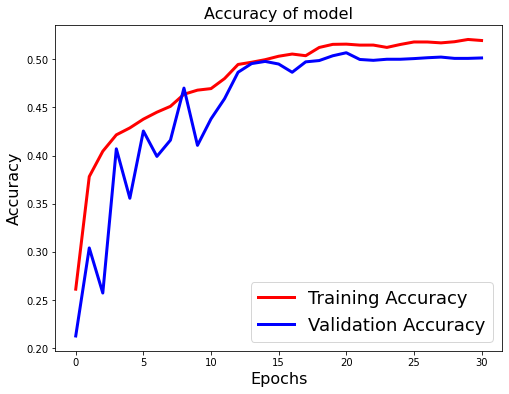

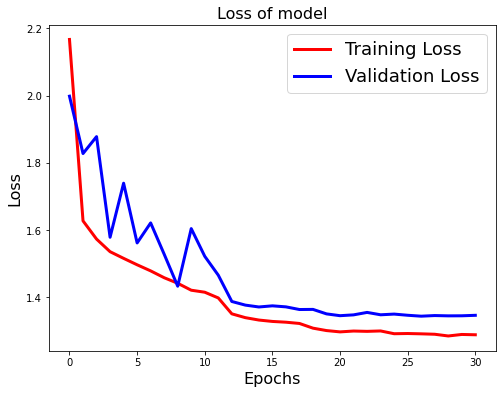

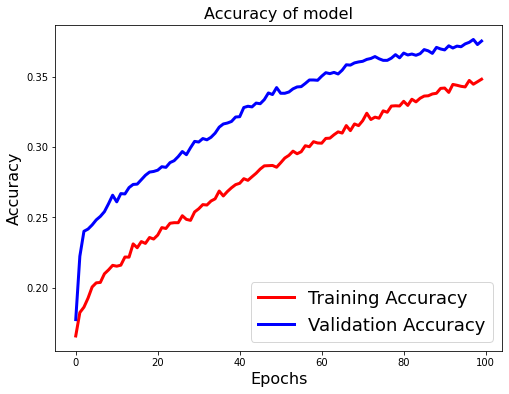

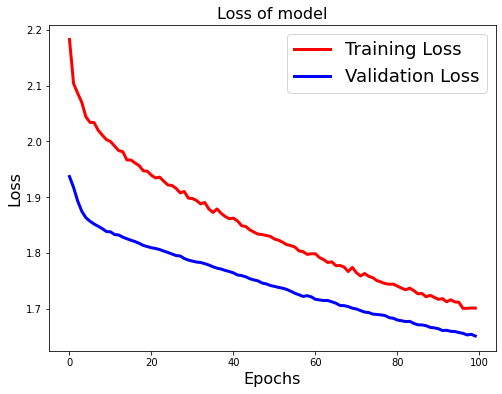

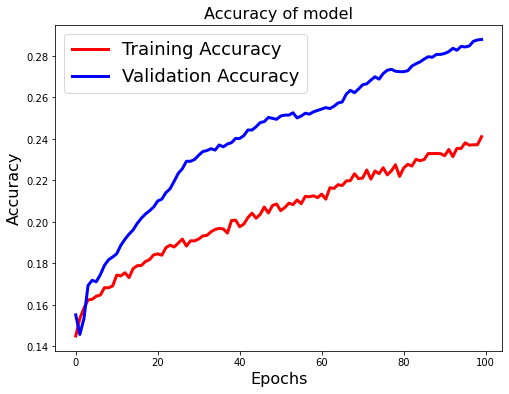

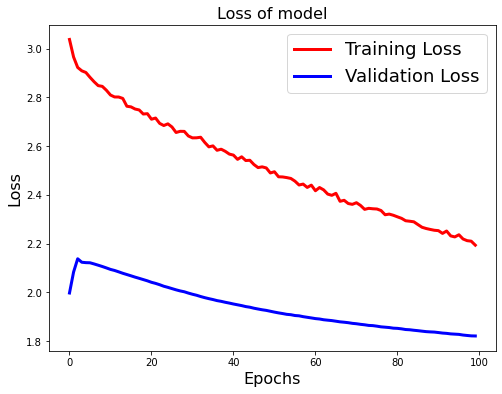

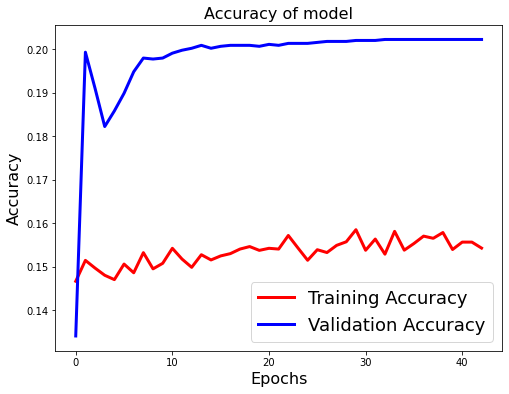

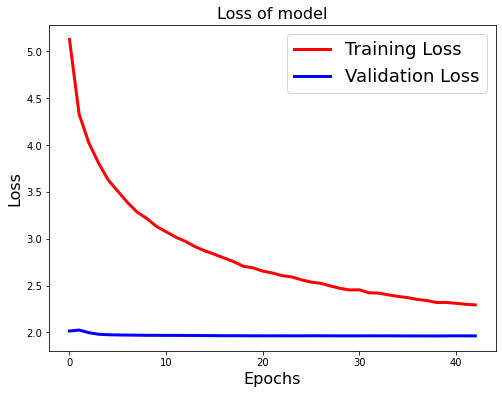

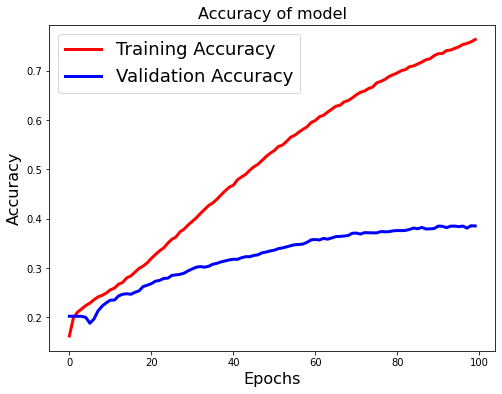

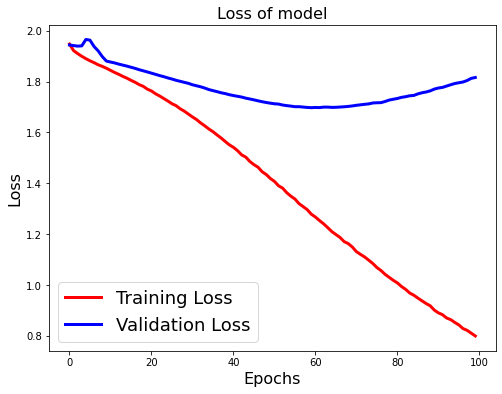

In [0]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=6,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.00025,
    factor=0.25,
    patience=3,
    min_lr=1e-6,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]
batch_size = 256
epochs = 200#45
lr = 0.001
optim = optimizers.Adam(learning_rate=lr)

models = []
model_hist = []
for i in range(len(model)):
  model[i].compile(loss='categorical_crossentropy',optimizer=optim,metrics=['accuracy'])
  hist = model[i].fit(Xtrain_img, y_train, batch_size=batch_size,validation_data=(Xvalid_img, y_valid),
    steps_per_epoch=len(Xtrain_img) / batch_size,
    epochs=epochs,
    callbacks=callbacks)
  plot(hist.history['accuracy'], hist.history['val_accuracy'], 'Accuracy')
  plot(hist.history['loss'], hist.history['val_loss'], 'Loss')
  model[i].save('/content/gdrive/My Drive/model_ensemble_{}.h5'.format(i))
  models.append(model[i])
  model_hist.append(hist)

In [0]:
#print(Xtrain_img.shape, Xtrain_hog.shape, y_train.shape)
#print(Xvalid_img.shape, Xvalid_hog.shape, y_valid.shape)
#models = []
val_acc = []
#test_acc = []
#for i in range(5):
#  model = tf.keras.models.load_model('/content/gdrive/My Drive/model_ensemble_{}.h5'.format(i))
#  models.append(model)
#  acc = model.evaluate(Xvalid_img,y_valid)[1]
#  print(acc)
#  val_acc.append(acc)
#  #test_acc.append(model.evaluate(test_set_x, test_set_y)[1])

for i in range(len(models)):
  acc = models[i].evaluate(Xvalid_img,y_valid)[1]
  print(acc)
  val_acc.append(acc)

model_73 = tf.keras.models.load_model("/content/gdrive/My Drive/model_73_7.h5")
models.append(model_73)
acc = model_73.evaluate([Xvalid_img,Xvalid_hog],y_valid)[1]
print(acc)
val_acc.append(acc)
#test_acc.append(model_73.evaluate([test_set_x, hog_feats_test], test_set_y)[1])

139/139 [==============================] - 0s 3ms/step - loss: 1.3455 - accuracy: 0.5066
0.5066366791725159
139/139 [==============================] - 0s 3ms/step - loss: 1.6510 - accuracy: 0.3753
0.3752530813217163
139/139 [==============================] - 0s 4ms/step - loss: 1.8213 - accuracy: 0.2880
0.28796401619911194
139/139 [==============================] - 1s 6ms/step - loss: 1.9635 - accuracy: 0.2022
0.20224972069263458
139/139 [==============================] - 2s 13ms/step - loss: 1.8162 - accuracy: 0.3854
0.38537684082984924
139/139 [==============================] - 1s 5ms/step - loss: 0.7069 - accuracy: 0.7339
0.7338582873344421


In [0]:
models=[]
val_acc = []
model_73 = tf.keras.models.load_model("/content/gdrive/My Drive/model_73_7.h5")
models.append(model_73)
acc = model_73.evaluate([Xvalid_img,Xvalid_hog],y_valid)[1]
print(acc)
val_acc.append(acc)

model_cnn2 = tf.keras.models.load_model('/content/gdrive/My Drive/model_cnn2_72.h5')
models.append(model_cnn2)
acc = model_cnn2.evaluate(Xvalid_img,y_valid)[1]
print(acc)
val_acc.append(acc)

139/139 [==============================] - 1s 6ms/step - loss: 0.7069 - accuracy: 0.7339
0.7338582873344421
139/139 [==============================] - 1s 6ms/step - loss: 0.3743 - accuracy: 0.8729
0.8728908896446228


In [0]:
import scipy.misc
import scipy.stats
from scipy import ndimage
def ensemble_voting(models, test_set_x):
  labels = []
  for m in models:
    print(m)
    if(str(m)=='<tensorflow.python.keras.engine.training.Model object at 0x7f525365b7f0>'):
      print("OK")
      predicts = np.argmax(m.predict([test_set_x,Xvalid_hog]), axis=1)
      print(predicts)
      labels.append(predicts)
    else :
      predicts = np.argmax(m.predict(test_set_x), axis=1)
      print(predicts)
      labels.append(predicts)
  # Ensemble with voting
  labels = np.array(labels)
  labels = np.transpose(labels, (1, 0))
  labels = scipy.stats.mode(labels, axis=1)[0]
  labels = np.squeeze(labels)

  return labels

In [0]:
def ensemble_average(members, testX):
	# make predictions
  yhats =[]
  for model in members :
    if(str(model)=='<tensorflow.python.keras.engine.training.Model object at 0x7f525365b7f0>'):
      print("OK")
      yhat = model.predict([testX,Xvalid_hog])
    else :
      yhat = model.predict(testX)
    yhats.append(yhat)

  yhats = np.array(yhats)
  print(yhats)
	# sum across ensemble members
  summed = np.sum(yhats, axis=0)
	# argmax across classes
  result = np.argmax(summed, axis=1)
  return result

In [0]:
def ensemble_weighted_average(members, weights, testX):
  yhats =[]
  for model in members:
    if(str(model)== '<tensorflow.python.keras.engine.training.Model object at 0x7f525365b7f0>'):
      print("OK")
      yhat = model.predict([testX,Xvalid_hog])
    else :
      yhat = model.predict(testX)
    yhats.append(yhat)
  yhats = np.array(yhats)
	# weighted sum across ensemble members
  summed = np.tensordot(yhats, weights, axes=((0),(0)))
	# argmax across classes
  result = np.argmax(summed, axis=1)
  return result

In [0]:
labels = ensemble_voting(models,Xvalid_img)

OK
[6 1 6 ... 3 1 1]
[6 0 6 ... 3 1 1]


In [0]:
labels_average = ensemble_average(models,Xvalid_img)

OK
[[[1.33977085e-01 7.75087585e-08 6.74409196e-02 ... 3.81879210e-01
   9.01910607e-05 4.11856294e-01]
  [2.67630368e-01 6.48219049e-01 4.35750782e-02 ... 4.90266575e-06
   4.05689627e-02 8.66398295e-07]
  [1.04656033e-01 4.41490061e-04 1.17177390e-01 ... 2.72294998e-01
   5.86937787e-03 4.32254702e-01]
  ...
  [1.39597352e-04 6.09100834e-12 2.15920666e-03 ... 4.92187042e-04
   1.56353265e-02 7.91952293e-03]
  [8.79219660e-05 9.99875903e-01 1.57436043e-05 ... 1.74837096e-05
   1.04709147e-06 1.58851208e-06]
  [8.26379255e-06 9.99984503e-01 3.59765932e-06 ... 3.19862556e-06
   2.41434179e-07 2.76494347e-07]]

 [[1.95573181e-01 2.16457993e-05 3.46336998e-02 ... 1.67198718e-01
   3.69731570e-04 6.01099670e-01]
  [5.97346842e-01 1.66179165e-01 2.19593778e-01 ... 5.28170448e-03
   1.09746940e-02 4.32109315e-04]
  [1.02088302e-02 4.78184992e-10 1.75201744e-02 ... 8.06865096e-02
   9.77134841e-05 8.91434312e-01]
  ...
  [3.77248099e-09 3.10158171e-22 1.52556268e-07 ... 1.55250302e-08
   7.16

In [0]:
labels_w_average = ensemble_weighted_average(models, val_acc, Xvalid_img)

OK


In [0]:
#labels_w_average_test = ensemble_weighted_average(models, test_acc, test_set_x)

In [0]:
rounded_labels=np.argmax(y_valid, axis=1)

In [0]:
from sklearn.metrics import accuracy_score
test_accuracy_score = accuracy_score(rounded_labels, labels_w_average)
print(test_accuracy_score)

0.8499437570303712


In [0]:
from sklearn.metrics import accuracy_score
test_accuracy_score = accuracy_score(rounded_labels, labels_average)
print(test_accuracy_score)

0.8434195725534308


In [0]:
from sklearn.metrics import accuracy_score
test_accuracy_score = accuracy_score(rounded_labels, labels)
print(test_accuracy_score)

0.8137232845894263
